In [247]:
import os
import subprocess
import sys
import numpy as np
import pandas as pd
from osgeo import gdal, ogr
import errno
import argparse
import itertools
import glob
from subprocess import call
from collections import defaultdict
import json
from datetime import timedelta
from datetime import datetime as dt
import shapely.wkt
from shapely.geometry import Polygon, box
from dateutil.relativedelta import relativedelta
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from multiprocessing import Pool, cpu_count
from itertools import repeat
import warnings

warnings.filterwarnings('ignore')

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3_client = boto3.client('s3')
gdal.SetConfigOption('AWS_NO_SIGN_REQUEST', 'YES')

import pandas as pd
from rasterstats import zonal_stats
import geopandas as gpd

In [248]:
def get_mgrs_shp(aoi_shp, bbox):
    aoi_mgrs_shp = 'sentinel2_bbox_mgrs.shp'
    try:
        os.remove(aoi_mgrs_shp)
    except OSError:
        pass
    if aoi_shp:
        call(str('ogr2ogr -clipsrc ' + aoi_shp + ' ' + aoi_mgrs_shp + ' ' + s2_tile), shell=True)
    else:
        min_x, min_y, max_x, max_y = bbox[0], bbox[1], bbox[2], bbox[3]
        call(str('ogr2ogr -f "ESRI Shapefile" ' + aoi_mgrs_shp + ' ' + s2_tile + ' -clipsrc ' + str(min_x)
                 + ' ' + str(min_y) + ' ' + str(max_x) + ' ' + str(max_y)), shell=True)
    return aoi_mgrs_shp


def shape_to_tiles(aoi_shp=None, bbox=None):
    aoi_mgrs_shp = get_mgrs_shp(aoi_shp, bbox)
    driver = ogr.GetDriverByName('ESRI Shapefile')
    ds = driver.Open(aoi_mgrs_shp)
    layer = ds.GetLayer(0)
    mgrs_list = []
    for feat in layer:
        mgrs_list.append(feat.GetField('tile'))
    del layer
    del ds
    return mgrs_list

def shape_to_polygon(shp_file=None, bbox=None):
    poly = None
    if bbox:
        poly = box(*bbox, ccw=True)
    elif shp_file:
        ds = ogr.Open(shp_file)
        layer = ds.GetLayer(0)
        for feat in layer:
            wkt_poly = feat.geometry().ExportToWkt()
        poly = shapely.wkt.loads(wkt_poly)
    return poly


def dates_dif(date1, date2):
    d0 = dt.strptime(date1, '%Y-%m-%d').date()
    d1 = dt.strptime(date2, '%Y-%m-%d').date()
    delta = abs(d1 - d0).days
    return delta


def validate_date(original_date, start_date, end_date):
    final_date = dt.strptime(str(original_date), '%Y-%m-%d')
    s_date = dt.strptime(str(start_date), '%Y-%m-%d')
    e_date = dt.strptime(str(end_date), '%Y-%m-%d')
    return s_date <= final_date <= e_date


def datetime_iterator(start_date=None, end_date=None):
    if not end_date:
        end_date = dt.today().date()
    if not start_date:
        start_date = end_date - timedelta(30)
    start_date = dt.strptime(str(start_date), '%Y-%m-%d').date()
    start_date = start_date.replace(day=1)
    end_date = dt.strptime(str(end_date), '%Y-%m-%d').date()
    while start_date <= end_date:
        yield start_date
        start_date = start_date + relativedelta(months=1)


def data_difference_days(product_dictionary, days_interval):
    from datetime import datetime as dt
    prev_date = None
    _dates = list(sorted(product_dictionary.keys()))
    n = len(_dates)
    for i in range(n - 1):
        if not prev_date:
            prev_date = _dates[i]
        date = _dates[i + 1]
        date_diff = dt.strptime(date, "%Y-%m-%d") - dt.strptime(prev_date, "%Y-%m-%d")
        days_diff = date_diff.days
        if days_diff < days_interval:
            product_dictionary.pop(date)
        else:
            prev_date = None
    return product_dictionary

In [249]:
def get_product_ids(start_date, end_date, cloud_threshold, data_days_interval, shape_file=None, bbox=None):
    source_s3_bucket = 'sentinel-cogs'
    source_s3_dir = 'sentinel-s2-l2a-cogs'
    tile_list = shape_to_tiles(aoi_shp=shape_file, bbox=bbox)
    tile_list = ['43RDM']
    poly = shape_to_polygon(shp_file=shape_file, bbox=bbox)
    print(f'Tiles found for the given AOI : {tile_list}')
    final_dict = {'single_tile': {}, 'merge_tile': {}}
    for tile in tile_list:
        utm_zone, lat_band, grid_square = str(tile)[:2], str(tile)[2], str(tile)[3:5]
        for _date in datetime_iterator(start_date, end_date):
            _year = int(_date.year)
            _month = int(_date.month)
            _PREFIX = os.path.join(source_s3_dir, str(utm_zone), str(lat_band), str(grid_square),
                                   str(_year), str(_month), '')
            _PREFIX = _PREFIX.replace('\\', '/')
            response = s3_client.list_objects(Bucket=source_s3_bucket, Prefix=_PREFIX)
            for content in response.get('Contents', []):
                key = content['Key']
                if key.endswith('.json'):
                    product_id = str(key).split('/')[-2]
                    pid_date = '-'.join([str(_year), str(_month).zfill(2), str(product_id[16:18]).zfill(2)])
                    if not validate_date(pid_date, start_date, end_date):
                        continue
                    result = s3.Object(source_s3_bucket, key)
                    data = json.load(result.get()['Body'])
                    tile_coord = data['geometry']['coordinates']
                    tile_cloud = data['properties']['eo:cloud_cover']
                    tile_poly = Polygon(tile_coord[0])
                    percent_area = poly.intersection(tile_poly).area / poly.area
                    print(f'Date: {pid_date}   Tile:{tile}   Cloud: {tile_cloud}   Area AOI/Tile: {percent_area}')
                    if percent_area <= 0.05:
                        continue
                    elif percent_area >= 0.99:
                        if not final_dict['single_tile'].get(str(pid_date)):
                            final_dict['single_tile'][str(pid_date)] = {}
                        final_dict['single_tile'][str(pid_date)][str('pids')] = [product_id]
                        final_dict['single_tile'][str(pid_date)][str('cloud_percentages')] = tile_cloud
                    else:
                        if not final_dict['merge_tile'].get(str(pid_date)):
                            final_dict['merge_tile'][str(pid_date)] = defaultdict(list)
                        final_dict['merge_tile'][str(pid_date)][str('pids')].append(product_id)
                        final_dict['merge_tile'][str(pid_date)][str('tile_ids')].append(tile)
                        final_dict['merge_tile'][str(pid_date)][str('cloud_percentages')].append(tile_cloud)
                        final_dict['merge_tile'][str(pid_date)][str('percent_areas')].append(percent_area)
    diff = dates_dif(start_date, end_date)
    diff = diff // data_days_interval
    diff = diff // 2  #### Data interval Buffer for user's input
    all_pids = {}
    if len(final_dict['single_tile']) >= diff:
        data = final_dict['single_tile']
        _dates = list(sorted(data.keys()))
        for date in _dates:
            print(f'Single Tile Metadata: {data[date]}')
            tile_cloud = data[date]['cloud_percentages']
            if tile_cloud > cloud_threshold:
                continue
            else:
                all_pids[str(date)] = data[date]['pids']
    else:
        data = final_dict['merge_tile']
        prev_date = None
        skip_one = False
        _dates = list(sorted(data.keys()))
        for date in _dates:
            if not prev_date:
                prev_date = date
                continue
            if skip_one:
                prev_date = date
                skip_one = False
                continue
            date_diff = dt.strptime(date, "%Y-%m-%d") - dt.strptime(prev_date, "%Y-%m-%d")
            days_diff = date_diff.days
            weighted_sum = 0
            sum_area_percents = 0
            for i in range(len(data[prev_date]['tile_ids'])):
                weighted_sum += data[prev_date]['cloud_percentages'][i] * data[prev_date]['percent_areas'][i]
                sum_area_percents += data[prev_date]['percent_areas'][i]

            for i in range(len(data[date]['tile_ids'])):
                weighted_sum += data[date]['cloud_percentages'][i] * data[date]['percent_areas'][i]
                sum_area_percents += data[date]['percent_areas'][i]

            avg_cloud_percent = weighted_sum / sum_area_percents
            if avg_cloud_percent > cloud_threshold:
                prev_date = date
                continue
            if days_diff >= 5:
                all_pids[str(prev_date)] = data[prev_date]['pids']
            elif days_diff < 5:
                all_pids[str(date)] = data[prev_date]['pids'] + data[date]['pids']
                skip_one = True
            prev_date = date
    final_pids = data_difference_days(all_pids, data_days_interval)
    return final_pids

In [250]:
source_s3_bucket = 'sentinel-cogs'
source_s3_dir = 'sentinel-s2-l2a-cogs'
def pid_to_path(prod_id, band):
    lst = prod_id.split('_')
    tile = lst[1]
    utm_zone, lat_band, grid_sq = str(tile)[:2], str(tile)[2], str(tile)[3:5]
    _year, _month, _day = lst[2][0:4], lst[2][4:6], lst[2][6:8]
    vsi_ext = '/vsis3/'
    band_tif = os.path.join(vsi_ext, source_s3_bucket, source_s3_dir, str(utm_zone), str(lat_band),
                            str(grid_sq),str(_year), str(int(_month)), str(prod_id), str(band) + '.tif')
    band_tif = band_tif.replace('\\', '/')
    return band_tif

In [251]:
def raster_to_array(raster_file):
    ds = gdal.Open(raster_file)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr
def get_ndvi(red, nir):
    arr = (nir - red) / (nir + red)
    arr[arr > 1] = 0
    arr[arr < -1] = 0
    return arr
def get_savi(red, nir, l): ## l = soil brightness correction factor could range from (0 -1)
    arr = (1.0 + l)*(nir - red) / (nir + red + l)
    return arr

def get_lswi(narrow_nir, swir):
    arr = (narrow_nir - swir) / (narrow_nir + swir)
    arr[arr > 1] = 0
    arr[arr < -1] = 0
    return arr

In [252]:
def clip_raster(raster_file, output_file=None, shp_file=None, bbox=None, out_width=None, out_height=None,
                      return_file=True):
#     ds_lst = list()
    ds = gdal.BuildVRT('', raster_file, VRTNodata=0, srcNodata=0)
    ds1 = gdal.Warp(output_file, ds, format='GTiff', dstNodata=0,
              dstSRS="+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0",
              cutlineDSName=shp_file, cropToCutline=True)
    arr = ds1.ReadAsArray()
    arr = arr.astype('int16')
    return arr

In [253]:
def write_raster(ref_raster, array, dst_filename, gdal_GDT_datatype):
    driver = gdal.GetDriverByName('GTiff')
    cols = array.shape[1]
    rows = array.shape[0]
    out_ds = driver.Create(dst_filename, cols, rows, 1, gdal_GDT_datatype)
    out_ds.GetRasterBand(1).WriteArray(array)

    # adding GeoTransform and Projection
    data0 = gdal.Open(ref_raster)
    geo_trans = data0.GetGeoTransform()
    proj = data0.GetProjection()
    del data0
    out_ds.SetGeoTransform(geo_trans)
    out_ds.SetProjection(proj)
    out_ds.FlushCache()
    del out_ds
    return dst_filename

In [254]:
s2_tile = '/home/ec2-user/SageMaker/sumit/crop-classification/unsupcc/satellite/satellite_tiles/s2_tile.shp'
shape_file = 'data/farm_data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp'
pids = get_product_ids('2021-10-01', '2022-03-30', 100, 5, 
                       shape_file=shape_file, bbox=None)

AttributeError: 'NoneType' object has no attribute 'GetLayer'

In [13]:
for key, val in pids.items():
    pid = val[0]
    date = pid.split('_')[2]
    f_path = os.path.join('data', 'indice', str(date))
    try:
        os.makedirs(f_path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    b4_path = pid_to_path(pid, 'B04')
    b8_path = pid_to_path(pid, 'B08')
    b8a_path = pid_to_path(pid, 'B8A')
    b11_path = pid_to_path(pid, 'B11')
    
    b4 = clip_raster(raster_file=b4_path, output_file='b4.tif', shp_file='data/farm_data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp')
    b8 = clip_raster(raster_file=b8_path, output_file='b8.tif', shp_file='data/farm_data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp')
    
    ndvi = get_ndvi(b4,b8)
    ndvi = np.around(ndvi, decimals=2, out=None)
    write_raster('b4.tif', ndvi, f'{f_path}/ndvi.tif', gdal.GDT_Float32)
    
    savi = get_savi(b4, b8, 0.428)
    savi = np.around(savi, decimals=2, out=None)
    write_raster('b4.tif', savi, f'{f_path}/savi.tif', gdal.GDT_Float32)
    b4 = b8 = ndvi = savi = None
    
    b8a = clip_raster(raster_file=b8a_path, output_file='b8a.tif', shp_file='data/farm_data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp')
    b11 = clip_raster(raster_file=b11_path, output_file='b11.tif', shp_file='data/farm_data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp')
    
    lswi = get_lswi(b8a, b11)
    lswi = np.around(lswi, decimals=2, out=None)
    write_raster('b8a.tif', lswi, f'{f_path}/lswi.tif', gdal.GDT_Float32)

In [96]:
geodf['Khasra_no'].iloc[2]

'560/146'

In [108]:
import random
geodf = gpd.read_file("data/farm_data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp")
date_dir = glob.glob('data/indice/*')
date_dir = sorted(date_dir)
randomlist = random.sample(range(0, len(geodf)), 10)
print(randomlist)
for i in randomlist:
    dd = defaultdict(list)
    f_path = f'indice_ts_data'
    try:
        os.makedirs(f_path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    for _date in date_dir:
        data_date = str(_date.split('/')[-1])
        dd['date'].append(data_date)
        for indice in ['ndvi', 'savi', 'lswi']:
            lst = zonal_stats(geodf[i:i+1], f'{_date}/{indice}.tif', stats="mean majority")
            dd[f'{indice}_mean'].append(lst[0]['mean'])
            dd[f'{indice}_majority'].append(lst[0]['majority'])
    df = pd.DataFrame(dd)
    df['Khasra_no'] = geodf['Khasra_no'].iloc[i]
    df['geometry'] = geodf['geometry'].iloc[i]
    df = df.round(3)
    df = df[['Khasra_no', 'date', 'ndvi_mean', 'ndvi_majority', 'savi_mean', 'savi_majority','lswi_mean', 'lswi_majority', 'geometry']]
    df.to_csv(f_path + f'/farm{i}.csv', index=False)
#     gdf = gpd.GeoDataFrame(df, geometry=geometry)
#     gdf.to_file(f_path + f'/farm{i}.shp')

[481, 605, 139, 216, 388, 370, 79, 263, 427, 176]


In [112]:
drs = glob.glob('indice_ts_data/*')
for item in drs:
    df = pd.read_csv(item)
    print(item, df.head(3))

indice_ts_data/farm388.csv    Unnamed: 0 Khasra_no      date  ndvi_mean  ndvi_majority  savi_mean  \
0           0   728/333  20211004      0.308           0.34      0.439   
1           1   728/333  20211009      0.289           0.32      0.413   
2           2   728/333  20211014      0.279           0.31      0.398   

   savi_majority  lswi_mean  lswi_majority  \
0           0.31     -0.026          -0.07   
1           0.45     -0.021          -0.02   
2           0.40     -0.042          -0.08   

                                            geometry  
0  POLYGON ((74.6617884367029 28.11409398296348, ...  
1  POLYGON ((74.6617884367029 28.11409398296348, ...  
2  POLYGON ((74.6617884367029 28.11409398296348, ...  
indice_ts_data/farm139.csv    Unnamed: 0  Khasra_no      date  ndvi_mean  ndvi_majority  savi_mean  \
0           0         41  20211004      0.289           0.26      0.413   
1           1         41  20211009      0.282           0.25      0.402   
2           2      

In [60]:
i = 1
import rasterio
from rasterio.mask import mask
import geopandas as gpd
shapefile = gpd.read_file("data/farm_data/Farmdata_Jaleubari_Ladhasar_Ratangarh_Churu_1-polygon.shp")
# extract the geometry in GeoJSON format
geoms = shapefile.geometry.values # list of shapely geometries
geometry = geoms[i] # shapely geometry
# transform to GeJSON format
from shapely.geometry import mapping
geoms = [mapping(geoms[i])]
# extract the raster values values within the polygon 
with rasterio.open("data/indice/20211218/ndvi.tif") as src:
     out_image, out_transform = mask(src, geoms, crop=True)

In [61]:
arr = out_image[0]

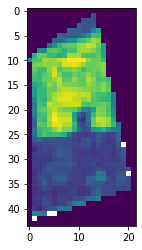

In [62]:
import matplotlib.pyplot as plt 
plt.imshow(arr)

In [63]:
a = arr[arr!=0]

In [64]:
a

array([0.19, 0.19, 0.19, 0.2 , 0.23, 0.2 , 0.19, 0.2 , 0.24, 0.24, 0.24,
       0.2 , 0.21, 0.33, 0.45, 0.26, 0.21, 0.23, 0.23, 0.23, 0.3 , 0.39,
       0.54, 0.52, 0.24, 0.26, 0.29, 0.39, 0.39, 0.5 , 0.53, 0.57, 0.65,
       0.62, 0.27, 0.37, 0.5 , 0.56, 0.57, 0.57, 0.63, 0.65, 0.7 , 0.67,
       0.58, 0.44, 0.36, 0.36, 0.56, 0.57, 0.54, 0.49, 0.54, 0.54, 0.63,
       0.65, 0.65, 0.61, 0.56, 0.44, 0.49, 0.59, 0.58, 0.51, 0.51, 0.48,
       0.5 , 0.65, 0.65, 0.66, 0.56, 0.54, 0.54, 0.57, 0.46, 0.33, 0.54,
       0.55, 0.65, 0.64, 0.64, 0.69, 0.71, 0.76, 0.76, 0.76, 0.75, 0.63,
       0.58, 0.58, 0.51, 0.59, 0.61, 0.63, 0.62, 0.64, 0.61, 0.71, 0.71,
       0.73, 0.7 , 0.64, 0.59, 0.58, 0.61, 0.62, 0.57, 0.52, 0.52, 0.62,
       0.7 , 0.55, 0.59, 0.59, 0.62, 0.59, 0.52, 0.57, 0.59, 0.59, 0.63,
       0.54, 0.51, 0.56, 0.6 , 0.71, 0.61, 0.54, 0.54, 0.59, 0.56, 0.57,
       0.63, 0.58, 0.55, 0.6 , 0.52, 0.51, 0.58, 0.59, 0.64, 0.68, 0.56,
       0.56, 0.63, 0.57, 0.56, 0.67, 0.62, 0.54, 0.

In [101]:
from scipy import stats

In [105]:
stats.mode(arr)[0][0]

array([ 0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ,
       -0.12, -0.12,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
      dtype=float32)

In [222]:
a = np.around(a, decimals=2, out=None)

In [106]:
arr

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  , -0.08, -0.09,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.13,
        -0.12, -0.12, -0.11, -0.1 , -0.11, -0.11, -0.09, -0.1 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.13, -0.14,
        -0.13, -0.12, -0.11, -0.12, -0.12, -0.12, -0.1 , -0.1 , -0.09],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.12, -0.12, -0.13, -0.13,
        -0.13, -0.12, -0.11, -0.12, -0.12, -0.11, -0.11, -0.11,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.13, -0.13, -0.13, -0.12, -0.11,
        -0.12, -0.13, -0.13, -0.11, -0.11, -0.11,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.13, -0.13, -0.13, -0.13, -0.13, -0.11, -0.11,
        -0.12, -0.12, -0.12,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.14, -0.12, -0.12, -0.13, -0.13, -0.12, -0.11, -0.11,
        -0.12,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],

In [109]:
arr

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3047,
        2826,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 3092, 3020, 2793,
        2699, 2661, 2524, 2384, 2386, 2338,    0],
       [   0,    0,    0,    0,    0,    0,    0, 2831, 2819, 2889, 2905,
        2990, 3024, 2942, 2996, 3191, 3178, 3353],
       [   0,    0,    0,    0,    0, 2772, 2772, 2781, 2884, 2909, 2929,
        2940, 2866, 2911, 2992, 3078, 3054,    0],
       [   0,    0,    0,    0, 2745, 2799, 2799, 2923, 2985, 2929, 2874,
        2834, 2885, 2895, 2929,    0,    0,    0],
       [   0,    0, 2734, 2721, 2715, 2715, 2758, 2977, 2917, 2851, 2877,
        2851,    0,    0,    0,    0,    0,    0],
       [   0, 2760, 2830, 2846, 2830, 2830, 2890, 2950, 2916, 2849,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   0, 2879, 2840, 2854, 2929, 2929, 2964, 2920,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],


In [113]:
arr

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3550,
        3415,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4014, 3832, 3538,
        3368, 3255, 3124, 2984, 2849, 2831,    0],
       [   0,    0,    0,    0,    0,    0,    0, 3709, 3775, 3724, 3694,
        3748, 3865, 3767, 3805, 3917, 3897, 4038],
       [   0,    0,    0,    0,    0, 3535, 3535, 3621, 3757, 3764, 3695,
        3681, 3672, 3668, 3726, 3847, 3845,    0],
       [   0,    0,    0,    0, 3530, 3605, 3605, 3715, 3749, 3743, 3718,
        3645, 3573, 3635, 3685,    0,    0,    0],
       [   0,    0, 3530, 3508, 3537, 3537, 3566, 3723, 3618, 3657, 3673,
        3646,    0,    0,    0,    0,    0,    0],
       [   0, 3636, 3638, 3592, 3646, 3646, 3672, 3706, 3654, 3598,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   0, 3726, 3646, 3623, 3737, 3737, 3744, 3708,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],


In [225]:
ds = gdal.Open('savi.tif')

In [226]:
ar = ds.ReadAsArray()

21.068045

In [192]:
ar

array([[3582, 3602, 3750, ..., 4096, 4012, 3964],
       [3552, 3388, 3322, ..., 4120, 4094, 4036],
       [3400, 3296, 3132, ..., 4128, 4104, 4108],
       ...,
       [3450, 3488, 3422, ..., 3193, 3168, 3062],
       [3364, 3470, 3430, ..., 3105, 3130, 3166],
       [3342, 3560, 3496, ..., 3082, 3068, 3177]], dtype=uint16)

In [197]:
shapefile.iloc[4]

OBJECTID                                                      5
Id                                                            0
Khasra_no                                               646/145
Area                                                    3.10929
Shape_Leng                                              784.085
                                    ...                        
age                                                           0
premiumD_1                                                 None
cscID                                                      None
stateID                                                    None
geometry      POLYGON ((465340.82919999957 3108887.5087, 465...
Name: 4, Length: 111, dtype: object

In [73]:
aa = (b8a[237][162:220]-b11[237][162:220])/(b8a[237][162:220]+b11[237][162:220])

In [67]:
b8a[237][162:220]

array([3057, 2812, 2934, 2934, 2675, 2299, 1942, 1750, 1775, 1999, 2137,
       2591, 3029, 3340, 3335, 3268, 3411, 3261, 3154, 3245, 3328, 3328,
       3279, 3187, 3198, 3092, 3192, 3337, 3402, 3389, 3451, 3353, 3320,
       3133, 2890, 2860, 3033, 3125, 3125, 3199, 3015, 3087, 2992, 2988,
       3001, 2986, 2975, 2907, 2850, 2855, 2833, 2874, 2820, 2915, 2972,
       2972, 3011, 3117], dtype=int16)

In [69]:
b11[237][162:220]

array([3222, 3108, 3028, 3028, 2743, 2398, 2017, 1879, 2142, 2389, 2578,
       2786, 3086, 3426, 3407, 3481, 3852, 3692, 3670, 3633, 3722, 3722,
       3488, 3445, 3597, 3832, 4065, 4084, 4128, 3876, 4017, 3906, 3757,
       3623, 3235, 3022, 3001, 3319, 3319, 3480, 3411, 3390, 3292, 3356,
       3448, 3383, 3445, 3221, 3087, 3134, 3020, 2797, 2940, 3299, 3394,
       3394, 3320, 3526], dtype=int16)

In [74]:
aa

array([-0.02627807, -0.05      , -0.01576652, -0.01576652, -0.01255076,
       -0.02107728, -0.01894418, -0.03554698, -0.09369415, -0.08887876,
       -0.09353128, -0.03626558, -0.00932134, -0.01271061, -0.01067932,
       -0.03156023, -0.06071871, -0.06198763, -0.07561547, -0.05641175,
       -0.05588652, -0.05588652, -0.03088518, -0.03890229, -0.05871965,
       -0.10687464, -0.12029764, -0.10066029, -0.09641434, -0.06703372,
       -0.07579004, -0.07618129, -0.06174933, -0.07252812, -0.05632653,
       -0.02754165,  0.00530328, -0.03010552, -0.03010552, -0.04207217,
       -0.06162465, -0.04678092, -0.04774029, -0.05800757, -0.06931307,
       -0.06233318, -0.07320872, -0.05124021, -0.03991915, -0.04658541,
       -0.03194943,  0.01357785, -0.02083333, -0.06179594, -0.06628966,
       -0.06628966, -0.04880746, -0.06156857])

In [46]:
(3222-3057)/(3222+3057)

0.026278069756330624

55450

In [ ]:
10 farms 30dates - 4 indices (6 min, max, median, mean, majority)
